In [1]:
%matplotlib inline
import sys
sys.path.append("..") # Adds the module to path

# Example 2.5 Single particle analysis

We extend the previous example to also predict the z position and the radius of the particle. To achieve this, we narrow the input space to a single optical setup.

## 1. Setup

Imports the objects needed for this example.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from deeptrack.scatterers import Sphere
from deeptrack.optics import Brightfield, IlluminationGradient
from deeptrack.noises import Poisson
from deeptrack.math import NormalizeMinMax
from deeptrack.generators import Generator
from deeptrack.augmentations import FlipLR, FlipUD, FlipDiagonal, PreLoad
from deeptrack.features import ConditionalSetFeature
from deeptrack.models import Convolutional


IMAGE_SIZE = 48

## 2. Defining the dataset

### 2.1 Defining the training set

The training set consists of simulated 48 by 48 pixel images, containing a single particle each. The particles are simulated as spheres with a radius between 0.5 microns and 1 micron, and a refractive index between 1.4 and 1.6. Its position in the camera plane is constrained to be within the image, and is sampled with a normal distribution with standard deviation of 5 pixel units in along the axis normal to the camera plane. 

In [3]:
particle = Sphere(
    position=lambda: np.random.rand(2) * IMAGE_SIZE,
    z=lambda: np.random.randn() * 5,
    radius=lambda: 0.5e-6 + np.random.rand() * 0.5e-6,
    refractive_index=lambda: 1.4 + np.random.rand() * 0.2,
    position_unit="pixel",
)

The particle is imaged using a brightfield microscope with NA of 0.7, illuminating laser wavelength of 633 nm, a magnification of 5, and a random illumination gradient.

In [4]:
gradient = IlluminationGradient(
    gradient=lambda: np.random.randn(2) * 3e-3,
    constant=lambda: np.random.rand() * 1
)

optics = Brightfield(
    NA=0.7,
    wavelength=633e-9,
    resolution=1e-6,
    magnification=5,
    padding=(32, 32, 32, 32),
    output_region=(0, 0, IMAGE_SIZE, IMAGE_SIZE),
    illumination=gradient
)

The noise is simulated as poisson noise with an signal to noise ratio between 10 and 50. The image is finally normalized by rescaling it to values between 0 and 1.

In [5]:
noise = Poisson(
    snr=lambda: 10 + np.random.rand() * 40
)

normalization = NormalizeMinMax(
    min=0,
    max=1,
)

We now define how these objects combine. Calling the optics object with the particle object tells DeepTrack to that is should image that particle using that optical device. We define an augmented version of `imaged_particle` which will increase the speed of the training. To bypass this augmentation during validation we create a conditional feature, which calls `imaged_particle` directly if `skip_augmentation=True`.

Finally we add in the noise and the normalization.

In [6]:
imaged_particle = optics(particle)

augmented_imaged_particle = PreLoad(
    FlipLR(FlipUD(FlipDiagonal(imaged_particle))),
    load_size=1,
    updates_per_reload=4)

conditional_imaged_particle = ConditionalSetFeature(
    on_false=augmented_imaged_particle,  
    on_true=imaged_particle,
    condition="skip_augmentations"
)

dataset = conditional_imaged_particle + noise + normalization

### 2.2 Defining the training label

The training label is extracted directly from the image as the `position` property divided by the image size, such that the posible values are contained within 0 and 1. Additionally, we append the z-position of the particle in pixels divided by 10, and the radius in microns.

In [7]:
def get_label(image):
    return [
        *(np.array(image.get_property("position")) / IMAGE_SIZE),
        image.get_property("z") / 10,
        image.get_property("radius") / 1e-6
    ]

### 2.3 Visualizing the dataset

We resolve and show 16 images, with a green circle indicating the particle position.

[0.9544236523574652, 0.17033466300143962, 0.5322130558188207, 0.9147084050345398]


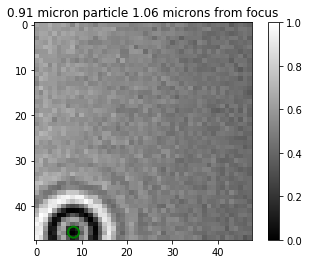

[0.6341399240163267, 0.6641824276177077, -0.3818782358100986, 0.820532763983105]


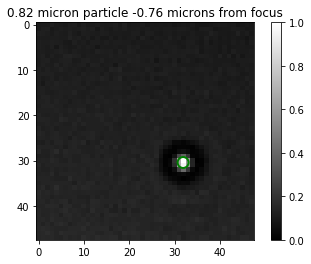

[0.16467693606157807, 0.29080111919607965, -0.34287617131795467, 0.527275907435375]


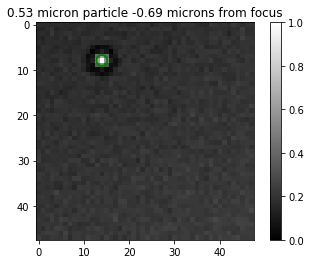

[0.7600683273435109, 0.5201966252768149, 0.22629838724930953, 0.8831853182596224]


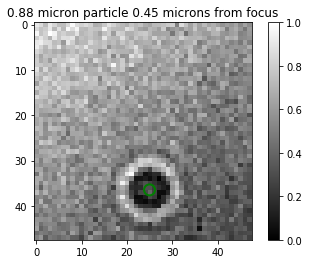

[0.9391962663282456, 0.4851917953182885, 0.24675998051792508, 0.6841459641290163]


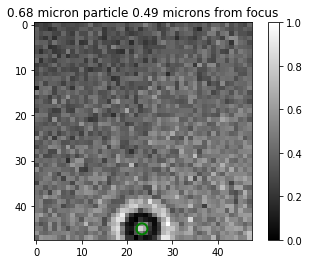

[0.7902743070253976, 0.9834775196493227, -0.47191113362326337, 0.6035456065063344]


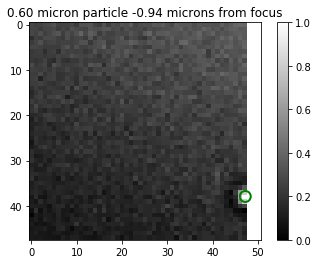

[0.1992519521674586, 0.6959572362370045, -0.5905805541029863, 0.7422954566642546]


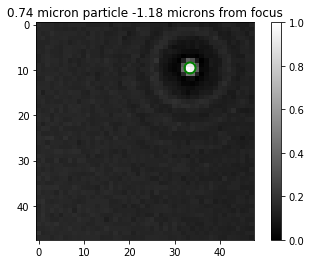

[0.06687812355180145, 0.7480502019420694, -0.5671406650809526, 0.5068346966148992]


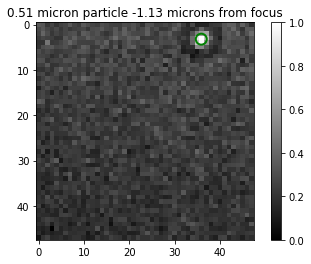

[0.877731721140241, 0.9343802448785813, 0.03525334644742685, 0.5255236178791922]


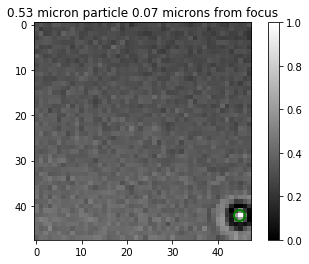

[0.31063947136585746, 0.8021385453383086, 0.20995718128110882, 0.5170699397219828]


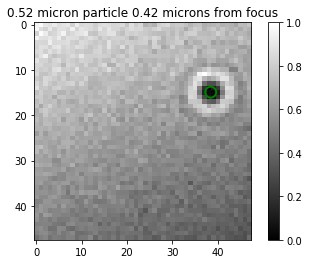

[0.8508183245520767, 0.8109802167123416, 0.9815499620730221, 0.9602983549757874]


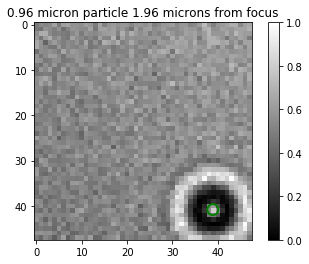

[0.6030607646818548, 0.7353539981864898, 0.38989575222601525, 0.7340556874989473]


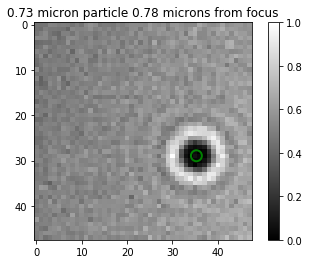

[0.8979418051729618, 0.5455960904189469, -0.15636337483134502, 0.6781516119798741]


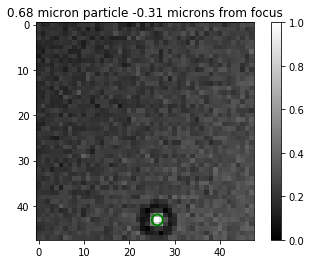

[0.6251578963769854, 0.46062822264996695, 0.46437609135013586, 0.6149682058505869]


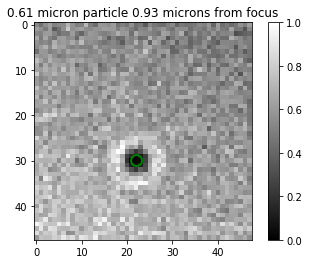

[0.6980141803637682, 0.3909314136981541, 0.6111256993450542, 0.5258498602074004]


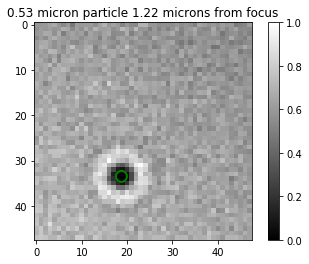

[0.838316993205719, 0.15057752650504763, 0.7908343254803349, 0.5926876806342691]


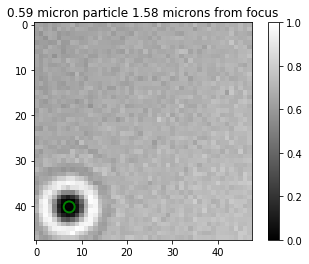

In [8]:
NUMBER_OF_IMAGES = 16

for _ in range(NUMBER_OF_IMAGES):
    dataset.update()
    image_of_particle = dataset.resolve(skip_augmentations=True)
    particle_label = get_label(image_of_particle)
    print(particle_label)
    plt.imshow(image_of_particle[..., 0], cmap="gray")
    
    pixel_size = image_of_particle.get_property("resolution") / image_of_particle.get_property("magnification")
    
    plt.colorbar()
    plt.scatter(particle_label[1] * IMAGE_SIZE, 
                particle_label[0] * IMAGE_SIZE, 
                s=120, facecolors='none', edgecolors="g", linewidth=2)
    plt.title("{0:4.2f} micron particle {1:4.2f} microns from focus".format(
        particle_label[3],
        particle_label[2] * pixel_size / 1e-7
    ))
    plt.show()
    

## 3. Defining the network

The network used is a Convolutional network, with a the pixel error as loss.

In [9]:
import tensorflow.keras.backend as K
import tensorflow.keras.optimizers as optimizers

metric_names = ["x", "y", "z", "r"]
def classwise_error(n):
    def error_function(T, P):
        return K.mean(K.abs(T[:, n] - P[:, n]), axis=0)
    error_function.__name__ = metric_names[n]
    return error_function

metrics=[classwise_error(n) for n in range(4)]

model = Convolutional(
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1),
    conv_layers_dimensions=(16, 32, 64, 128),
    dense_layers_dimensions=(32, 32),
    dropout=(0.15, 0.15),
    number_of_outputs=4,
    loss="mae",
    metrics=metrics,
    optimizer=optimizers.Adam(lr=0.001, amsgrad=True)
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 46, 46, 16)        160       
_________________________________________________________________
spatial_dropout2d (SpatialDr (None, 46, 46, 16)        0         
_________________________________________________________________
pooling_1 (MaxPooling2D)     (None, 23, 23, 16)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 21, 21, 32)        4640      
_________________________________________________________________
spatial_dropout2d_1 (Spatial (None, 21, 21, 32)        0         
_________________________________________________________________
pooling_2 (MaxPooling2D)     (None, 10, 10, 32)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 8, 8, 64)          1

## 4. Training the network

The network is trained similarly to example 2.

In [11]:
training_set_size = int(2e5)
validation_set_size = 4000

training_set = [dataset.update().resolve() for _ in range(training_set_size)]
training_labels = [get_label(image) for image in training_set]

validation_set = [dataset.update().resolve(skip_augmentations=True) for _ in range(validation_set_size)]
validation_labels = [get_label(image) for image in validation_set]

h = model.fit(np.array(training_set), 
              np.array(training_labels),
              class_weight={0:20, 1:20, 2:2, 3:4},
              validation_data=(np.array(validation_set), 
                               np.array(validation_labels)),
              epochs=25)

Epoch 1/25
6250/6250 [==============================] - 65s 10ms/step - loss: 0.4488 - x: 0.0148 - y: 0.0149 - z: 0.1077 - r: 0.0594 - val_loss: 0.0480 - val_x: 0.0129 - val_y: 0.0136 - val_z: 0.1102 - val_r: 0.0555
Epoch 2/25
6250/6250 [==============================] - 47s 7ms/step - loss: 0.4432 - x: 0.0142 - y: 0.0143 - z: 0.1057 - r: 0.0582 - val_loss: 0.0464 - val_x: 0.0112 - val_y: 0.0130 - val_z: 0.1050 - val_r: 0.0565
Epoch 3/25
6250/6250 [==============================] - 50s 8ms/step - loss: 0.4388 - x: 0.0140 - y: 0.0140 - z: 0.1044 - r: 0.0570 - val_loss: 0.0477 - val_x: 0.0128 - val_y: 0.0116 - val_z: 0.1126 - val_r: 0.0538
Epoch 4/25
6250/6250 [==============================] - 50s 8ms/step - loss: 0.4364 - x: 0.0139 - y: 0.0139 - z: 0.1035 - r: 0.0565 - val_loss: 0.0439 - val_x: 0.0113 - val_y: 0.0126 - val_z: 0.0990 - val_r: 0.0528
Epoch 5/25
6250/6250 [==============================] - 51s 8ms/step - loss: 0.4327 - x: 0.0138 - y: 0.0138 - z: 0.1022 - r: 0.0557 - val_l

## 5. Evaluating the network

### 5.1 Loss vs validation
We plot the metrics evaluated on the training data compared to the validation data to spot potential overtraining. 

[]

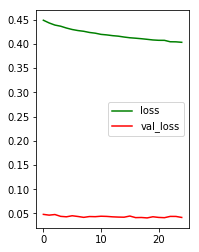

In [12]:
plt.subplot(1, 2, 1)
plt.plot(h.history["loss"], 'g')
plt.plot(h.history["val_loss"], 'r')
plt.legend(["loss", "val_loss"])
plt.plot()

### 5.2 Prediction visualization

We show a few images, with the true position as a green circle, and the predicted position as a blue cross.

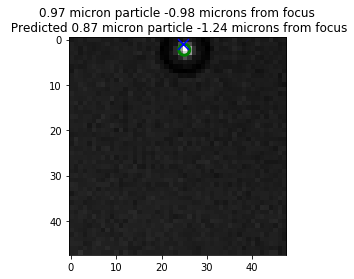

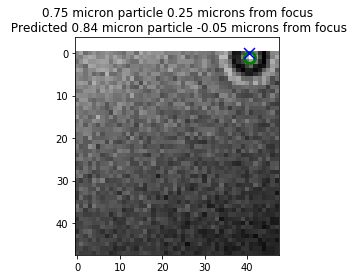

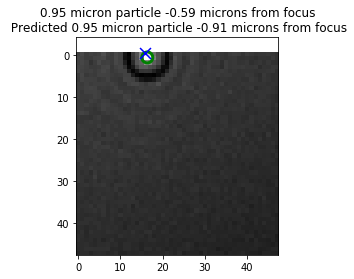

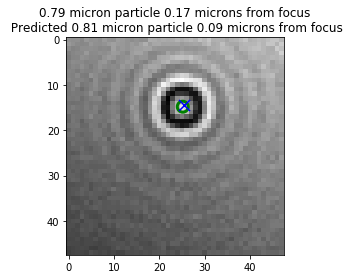

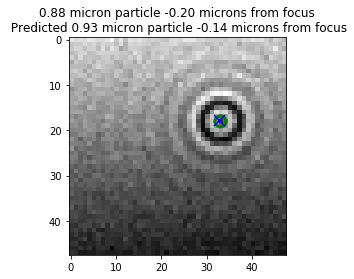

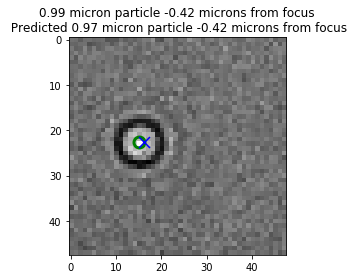

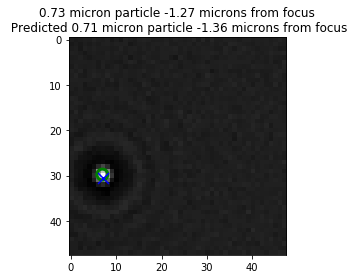

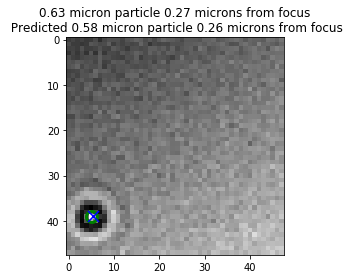

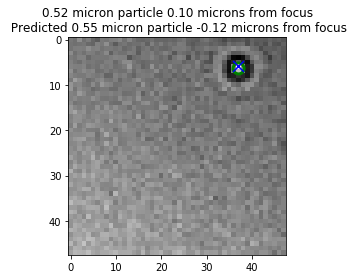

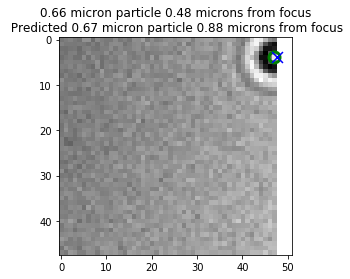

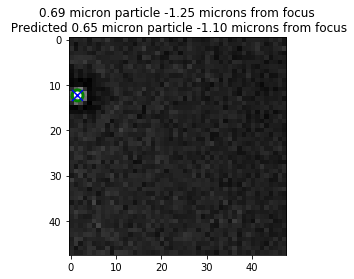

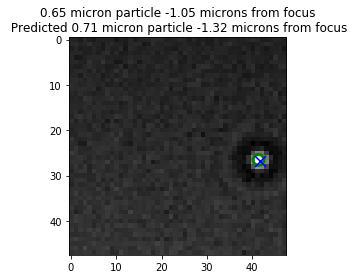

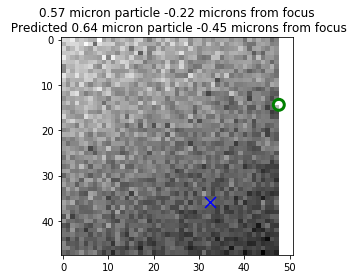

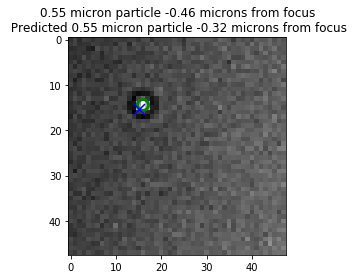

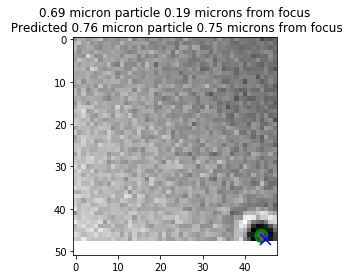

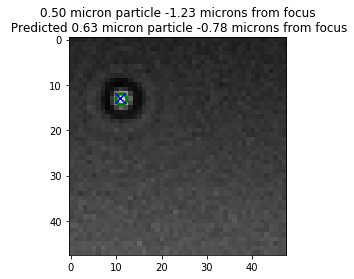

In [13]:
NUMBER_OF_IMAGES = 16

title_format = "{0:4.2f} micron particle {1:4.2f} microns from focus\n Predicted {2:4.2f} micron particle {3:4.2f} microns from focus"

for _ in range(NUMBER_OF_IMAGES):
    dataset.update()
    image_of_particle = dataset.resolve(skip_augmentations=True)
    particle_label = get_label(image_of_particle)
    prediction = model.predict(np.array([image_of_particle]))
    
    plt.imshow(image_of_particle[:, :, 0], cmap="gray")
    plt.scatter(particle_label[1] * IMAGE_SIZE, 
                particle_label[0] * IMAGE_SIZE, 
                marker='o', s=120, facecolors='none', edgecolors="g", linewidth=3)
    
    plt.scatter(prediction[0, 1] * IMAGE_SIZE, 
                prediction[0, 0] * IMAGE_SIZE, 
                marker='x', s=120, c="b")
    
    plt.title(title_format.format(
        particle_label[3],
        particle_label[2] * pixel_size / 1e-7,
        prediction[0, 3],
        prediction[0, 2] * pixel_size / 1e-7
    ))
    plt.show()

### 5.3 Prediction vs actual

We show the prediction of each output versus the ground truth

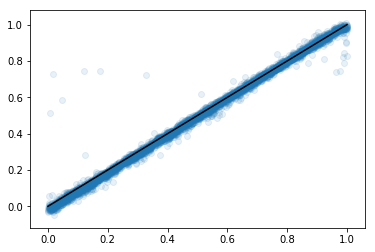

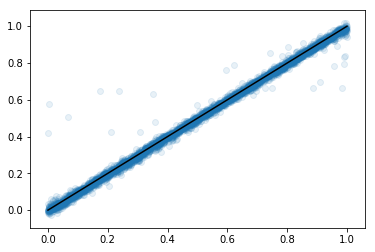

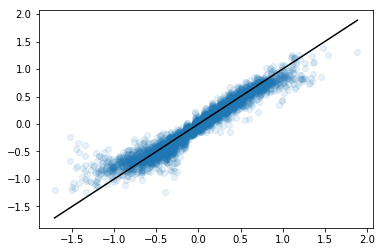

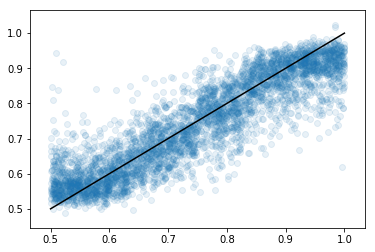

In [14]:
validation_prediction = model.predict(np.array(validation_set))
labels = np.array(validation_labels)
for col in range(validation_prediction.shape[-1]):
    label_col = labels[:, col]
    prediction_col = validation_prediction[:, col]
    plt.scatter(label_col, prediction_col, alpha=0.1)
    
    plt.plot([np.min(label_col), np.max(label_col)], 
             [np.min(label_col), np.max(label_col)], c='k')
    plt.show()

### 5.4 Prediction vs property value

We show the pixel error as a function of some properties.

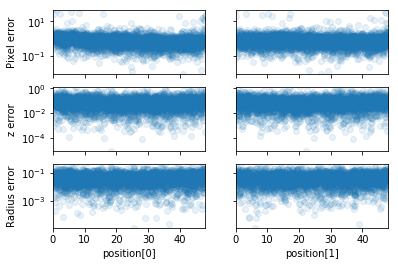

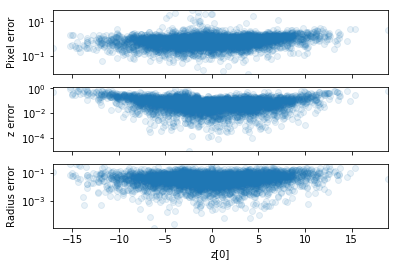

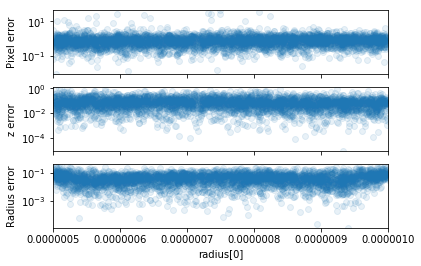

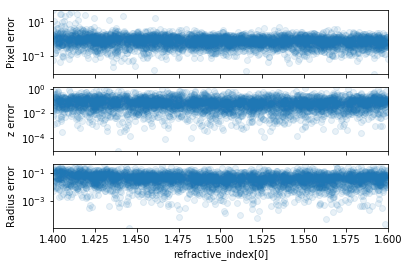

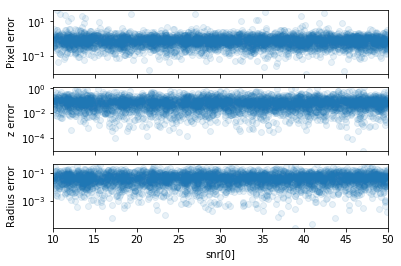

In [15]:
properties = ["position", "z", "radius", "refractive_index", "snr"]

validation_prediction = model.predict(np.array(validation_set))

metrics = [
    np.sqrt(np.sum(np.square(validation_labels - validation_prediction)[:,:2], axis=-1)) * IMAGE_SIZE,
    np.abs(validation_labels - validation_prediction)[:, 2],
    np.abs(validation_labels - validation_prediction)[:, 3]
]

y_labels = [
    "Pixel error",
    "z error",
    "Radius error"
]


for property_name in properties:
    property_values = np.array([image.get_property(property_name) for image in validation_set])
    if property_values.ndim == 1:
        property_values = np.expand_dims(property_values, axis=-1)
        
    for col in range(property_values.shape[1]):
        for row in range(len(metrics)):
            values = property_values[:, col]

            ax = plt.subplot(len(metrics), 
                        property_values.shape[1], 
                        row * property_values.shape[1] + col + 1)

            plt.scatter(values, metrics[row], alpha=0.1)
            plt.xlim([np.min(values), np.max(values)])
            plt.ylim([np.min(metrics[row]), np.max(metrics[row])])
            plt.yscale("log")
            if col == 0:
                plt.ylabel(y_labels[row])
            else:
                ax.set_yticklabels([])
                
            if row == len(metrics) - 1:
                plt.xlabel("{0}[{1}]".format(property_name, col))
            else:
                ax.set_xticklabels([])
    plt.show()